# EDA for NASA Turbo Fan Jet Engine Dataset

An unexpected engine failure leads to costly downtime and safety risks.
The goal here is to anticipate an engine's failure early enough to enable
preventive maintenance decisions.

This EDA focuses on:
- Identifying sensors with monotonic or accelerating degradation
- Understanding variability and trends across engines
- Assessing whether degradation patterns are consistent enough to model

Dataset link: [NASA's Prognostics Data Repository](https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/)
Listed as Dataset #6

**Dataset Overview**

**Source:** NASA CMAPSS FD001

**Unit of observation:** One engine at one operational cycle

**Time index:** `time_in_cycles` (increasing integer per engine)

**Target variable:** Remaining Useful Life (RUL)

**Independent variable:** Sensor Readings

Each engine begins at a healthy state and degrades until failure.
Sensor readings are multivariate time series indexed by engine and cycle.

**EDA Plan**

This EDA is guided by the following questions:

1. Which sensors exhibit degradation trends or monotonic behavior as engines approach failure?

2. How do sensor signals evolve over an engine’s lifecycle, and what degradation trends appear as failure approaches?

3. Do degradation patterns differ across engines with different lifespan groups, or are sensor distributions consistent across those groups?


In [35]:
# Import data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math
from pathlib import Path

In [36]:
# Global plot appearance settings
mpl.rcParams.update({

    # Figure & Axes
    "figure.figsize": (10, 6),
    "figure.dpi": 120,
    "figure.facecolor": "#0b0f1a",
    "axes.facecolor": "#0b0f1a",
    "axes.edgecolor": "#8aa2c8",
    "axes.linewidth": 0.8,

    # Grid
    "axes.grid": True,
    "grid.color": "#1f2a44",
    "grid.linestyle": "--",
    "grid.linewidth": 0.6,
    "grid.alpha": 0.6,

    #  Text
    "text.color": "#e6e6eb",
    "axes.labelcolor": "#e6e6eb",
    "xtick.color": "#c7d0e0",
    "ytick.color": "#c7d0e0",
    "axes.titleweight": "bold",
    "axes.titlesize": 14,
    "axes.labelsize": 12,

    # ===== Ticks =====
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.minor.size": 2,
    "ytick.minor.size": 2,

    # Lines
    "lines.linewidth": 2.0,
    "lines.markersize": 5,

    # Legend
    "legend.facecolor": "#0b0f1a",
    "legend.edgecolor": "#8aa2c8",
    "legend.framealpha": 0.9,
    "legend.fontsize": 10,

    # Color Cycle
    "axes.prop_cycle": mpl.cycler(color=[
        "#4cc9f0",
        "#f72585",
        "#b5179e",
        "#7209b7",
        "#560bad",
        "#480ca8",
        "#3a86ff",
        "#ffd166"
    ])
})

In [37]:
# Load in dataset and label columns
from src.data_loader import load_fd001

PROJECT_ROOT = Path().resolve().parents[0]
DATA_PATH = PROJECT_ROOT / 'data' / 'processed' / 'fd001_processed.csv'
df = load_fd001(DATA_PATH)

In [38]:
print(df)

       unit_number  time_in_cycles  operation_setting_1  operation_setting_2  \
0                1               1              -0.0007              -0.0004   
1                1               2               0.0019              -0.0003   
2                1               3              -0.0043               0.0003   
3                1               4               0.0007               0.0000   
4                1               5              -0.0019              -0.0002   
...            ...             ...                  ...                  ...   
20626          100             196              -0.0004              -0.0003   
20627          100             197              -0.0016              -0.0005   
20628          100             198               0.0004               0.0000   
20629          100             199              -0.0011               0.0003   
20630          100             200              -0.0032              -0.0005   

       operation_setting_3  sensor_1  s

In [39]:
# Check for nulls and basic statistics
print(df.info())
print('------' * 12)
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   unit_number          20631 non-null  int64  
 1   time_in_cycles       20631 non-null  int64  
 2   operation_setting_1  20631 non-null  float64
 3   operation_setting_2  20631 non-null  float64
 4   operation_setting_3  20631 non-null  float64
 5   sensor_1             20631 non-null  float64
 6   sensor_2             20631 non-null  float64
 7   sensor_3             20631 non-null  float64
 8   sensor_4             20631 non-null  float64
 9   sensor_5             20631 non-null  float64
 10  sensor_6             20631 non-null  float64
 11  sensor_7             20631 non-null  float64
 12  sensor_8             20631 non-null  float64
 13  sensor_9             20631 non-null  float64
 14  sensor_10            20631 non-null  float64
 15  sensor_11            20631 non-null 

In [40]:
# Get max cycle for each engine: Per-engine lifecycle
rul_lookup = df.groupby("unit_number")["time_in_cycles"].max().reset_index() # cycle at which engine failed
rul_lookup.columns = ["unit_number", "max_cycle"]
rul_lookup

,unit_number,max_cycle
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


For each engine in the training set, RUL is defined as the difference between the engine's failure cycle and the current cycle.


We create our target and assume that time_in_cycles increases by the same amount each timestep without gaps and
also note that the last observation is considered the failure point for a cycle. With this we can extract a supervised time-series signal

In [41]:
# Merge max_cycle for each unit back into the dataframe to calculate RUL
df = df.merge(rul_lookup, on="unit_number")
df['RUL'] = df["max_cycle"] - df["time_in_cycles"]

In [42]:
# Check unique values in each feature and append those with 1 or less to dropping list
unique_numbers_1_todrop = []

for x, y in df.nunique().sort_values().items():
    if y <= 1:
        unique_numbers_1_todrop.append(x)
        
unique_numbers_1_todrop

['sensor_10',
 'sensor_19',
 'sensor_18',
 'operation_setting_3',
 'sensor_1',
 'sensor_16',
 'sensor_5']

In [43]:
# Drop features with only one unique value
df = df.drop(columns=unique_numbers_1_todrop)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   unit_number          20631 non-null  int64  
 1   time_in_cycles       20631 non-null  int64  
 2   operation_setting_1  20631 non-null  float64
 3   operation_setting_2  20631 non-null  float64
 4   sensor_2             20631 non-null  float64
 5   sensor_3             20631 non-null  float64
 6   sensor_4             20631 non-null  float64
 7   sensor_6             20631 non-null  float64
 8   sensor_7             20631 non-null  float64
 9   sensor_8             20631 non-null  float64
 10  sensor_9             20631 non-null  float64
 11  sensor_11            20631 non-null  float64
 12  sensor_12            20631 non-null  float64
 13  sensor_13            20631 non-null  float64
 14  sensor_14            20631 non-null  float64
 15  sensor_15            20631 non-null 

In [44]:
# Sanity check for dropped features
df.nunique().sort_values()

sensor_6                  2
sensor_17                13
operation_setting_2      13
sensor_8                 53
sensor_13                56
max_cycle                66
unit_number             100
sensor_20               120
RUL_capped              126
operation_setting_1     158
sensor_11               159
sensor_2                310
time_in_cycles          362
RUL                     362
sensor_12               427
sensor_7                513
sensor_15              1918
sensor_3               3012
sensor_4               4051
sensor_21              4745
sensor_14              6078
sensor_9               6403
dtype: int64

In [45]:
# Square root rule to decide number of bins
num_bins = int(np.sqrt(20631))

We can see that remaining useful life is pretty much constant before 125 which will end up dominating the loss: without capping the dataset is dominated by early lifecycle observations
which are less important in terms of degradation signal.

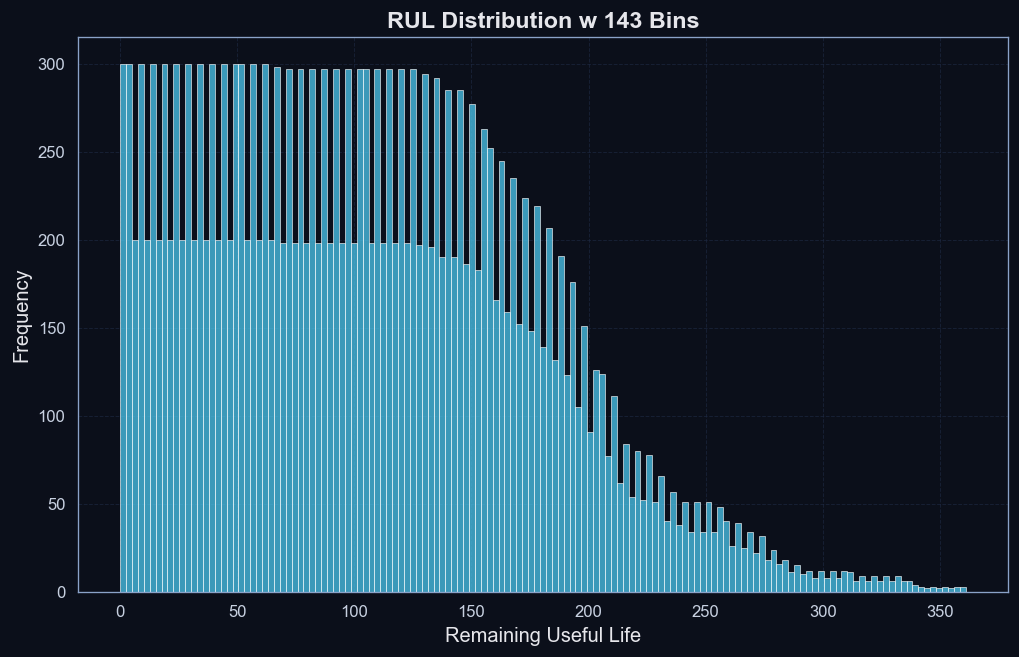

In [46]:
# Plot RUL distribution with square root rule
sns.histplot(data=df[125:], x="RUL", bins=num_bins)
plt.title("RUL Distribution w 143 Bins")
plt.xlabel("Remaining Useful Life")
plt.ylabel("Frequency")
# plt.savefig('../plots/eda_rul_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

We cap the RUL to capture the pattern when it matters more - closer to engine failure.

In [47]:
# Cap the RUL
RUL_CAP = 125
df['RUL_capped'] = df["RUL"].clip(upper=RUL_CAP)

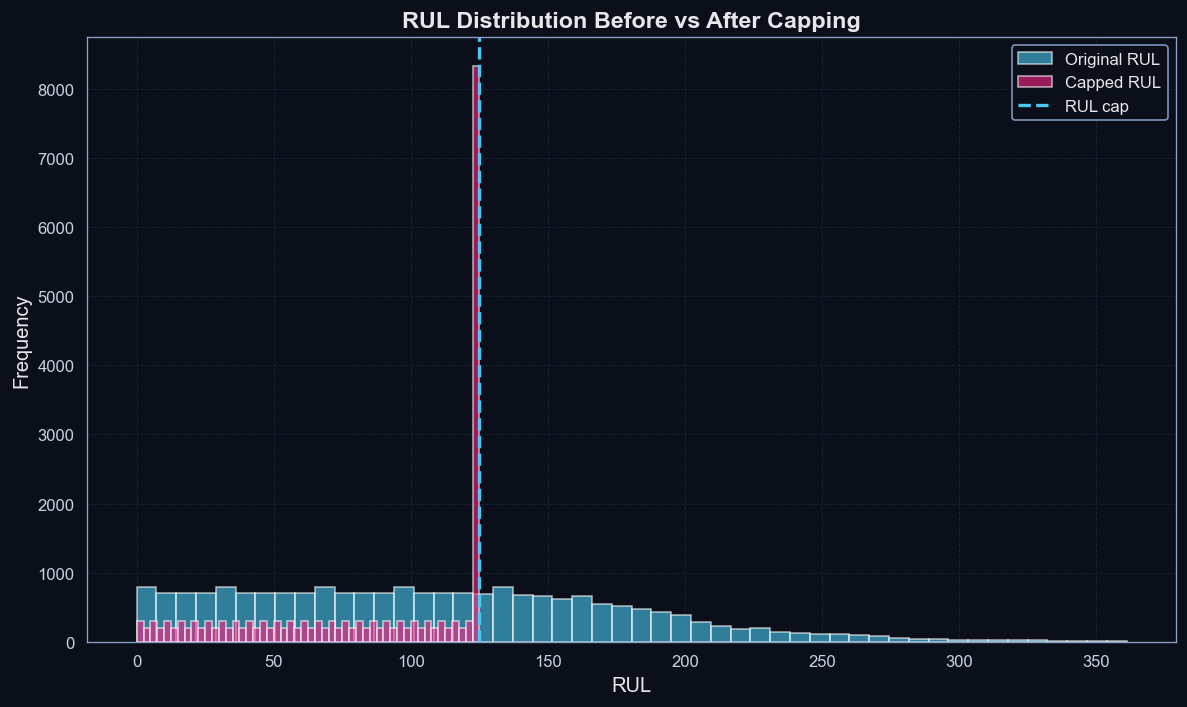

In [48]:
# Verify RUL cap
plt.hist(df["RUL"], bins=50, alpha=0.6, label="Original RUL")
plt.hist(df["RUL_capped"], bins=50, alpha=0.6, label="Capped RUL")
plt.axvline(RUL_CAP, linestyle="--", linewidth=2, label="RUL cap")
plt.xlabel("RUL")
plt.ylabel("Frequency")
plt.title("RUL Distribution Before vs After Capping")
plt.legend()
plt.tight_layout()
# plt.savefig('../plots/eda_rul_distribution_after_capping.png', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
# Compute engine lifetimes
engine_life = (
    df.groupby('unit_number')['time_in_cycles']
    .max()
    .reset_index(name='max_cycle')
)

In [50]:
# Get engines with different length cycles to account for variable types of degradation
q33 = engine_life['max_cycle'].quantile(.33)
q66 = engine_life['max_cycle'].quantile(.66)

In [51]:
def life_group(x):
    """ Function to assign the engines to one of three groups depending on its lifespan"""
    if x <= q33:
        return 'short'
    elif x<=q66:
        return 'medium'
    else:
        return 'long'

In [52]:
# Creating a column that categorizes each engine into a group and select one from each
engine_life['life_group'] = engine_life['max_cycle'].apply(life_group)

selected_units = (
    engine_life.groupby('life_group').head(3)['unit_number']
)

In [53]:
engine_life

,unit_number,max_cycle,life_group
0,1,192,medium
1,2,287,long
2,3,179,short
3,4,189,medium
4,5,269,long
...,...,...,...
95,96,336,long
96,97,202,medium
97,98,156,short
98,99,185,short


In [54]:
# View summary cycle stats for lifecycle groups
print('Short lived engines','----' * 10)
print(engine_life[engine_life['life_group'] == 'short'].describe())
print('Medium lived engines' ,'----' * 10)
print(engine_life[engine_life['life_group'] == 'medium'].describe())
print('Long lived engines', '----' * 10)
print(engine_life[engine_life['life_group'] == 'long'].describe())

Short lived engines ----------------------------------------
       unit_number   max_cycle
count    33.000000   33.000000
mean     50.818182  162.030303
std      29.206650   15.494928
min       3.000000  128.000000
25%      27.000000  154.000000
50%      57.000000  163.000000
75%      74.000000  174.000000
max      99.000000  185.000000
Medium lived engines ----------------------------------------
       unit_number   max_cycle
count     35.00000   35.000000
mean      46.00000  199.800000
std       27.55209    8.054228
min        1.00000  188.000000
25%       24.00000  194.000000
50%       43.00000  199.000000
75%       69.50000  207.000000
max      100.00000  213.000000
Long lived engines ----------------------------------------
       unit_number   max_cycle
count    32.000000   32.000000
mean     55.093750  259.093750
std      30.496282   39.097363
min       2.000000  214.000000
25%      29.500000  230.750000
50%      57.500000  256.500000
75%      82.250000  279.250000
max      96

In [55]:
# Select 3 engines from each group type (short, medium, long)
selected_units

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
11    12
Name: unit_number, dtype: int64

In [56]:
# Create normalized life fraction column
df['life_fraction'] = (df['time_in_cycles'] /
                       df['max_cycle'])
df

,unit_number,time_in_cycles,operation_setting_1,operation_setting_2,sensor_2,sensor_3,sensor_4,sensor_6,sensor_7,sensor_8,...,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL,RUL_capped,max_cycle,life_fraction
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,...,2388.02,8138.62,8.4195,392,39.06,23.4190,191,125,192,0.005208
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,...,2388.07,8131.49,8.4318,392,39.00,23.4236,190,125,192,0.010417
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,...,2388.03,8133.23,8.4178,390,38.95,23.3442,189,125,192,0.015625
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,...,2388.08,8133.83,8.3682,392,38.88,23.3739,188,125,192,0.020833
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,...,2388.04,8133.80,8.4294,393,38.90,23.4044,187,125,192,0.026042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,...,2388.26,8137.60,8.4956,397,38.49,22.9735,4,4,200,0.980000
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,...,2388.22,8136.50,8.5139,395,38.30,23.1594,3,3,200,0.985000
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,...,2388.24,8141.05,8.5646,398,38.44,22.9333,2,2,200,0.990000
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,...,2388.23,8139.29,8.5389,395,38.29,23.0640,1,1,200,0.995000


In [57]:
selected_units
# engine_life['unit_number'[selected_units]]

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
11    12
Name: unit_number, dtype: int64

In [58]:
# assign list of sensors to a variable to generate subplots in next cell
sensor_col = [ 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7',
       'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']

## Which sensors exhibit degradation trends or monotonic behavior as engines approach failure?

Here is RUL plotted against all sensors across the engines to get a rough picture of which sensors give the best signal and are monotonic - meaning they encode degradation
These sensors are prime candidates for modeling/feature engineering:
- sensor 2
- sensor 3
- sensor 4
- sensor 11
- sensor 15

The other sensors also pick up some signal but are unlikely to contributte useful predictive signal:
- sensor 7
- sensor 8
- sensor 12
- sensor 13
- sensor 20
- sensor 21
Some sensors have a variance that increases as RUL decreases:
- sensor 9
- sensor 14
- sensor 17 gives discrete horizontal bands - we may be able to turn this into a bucket or qualitative variable.

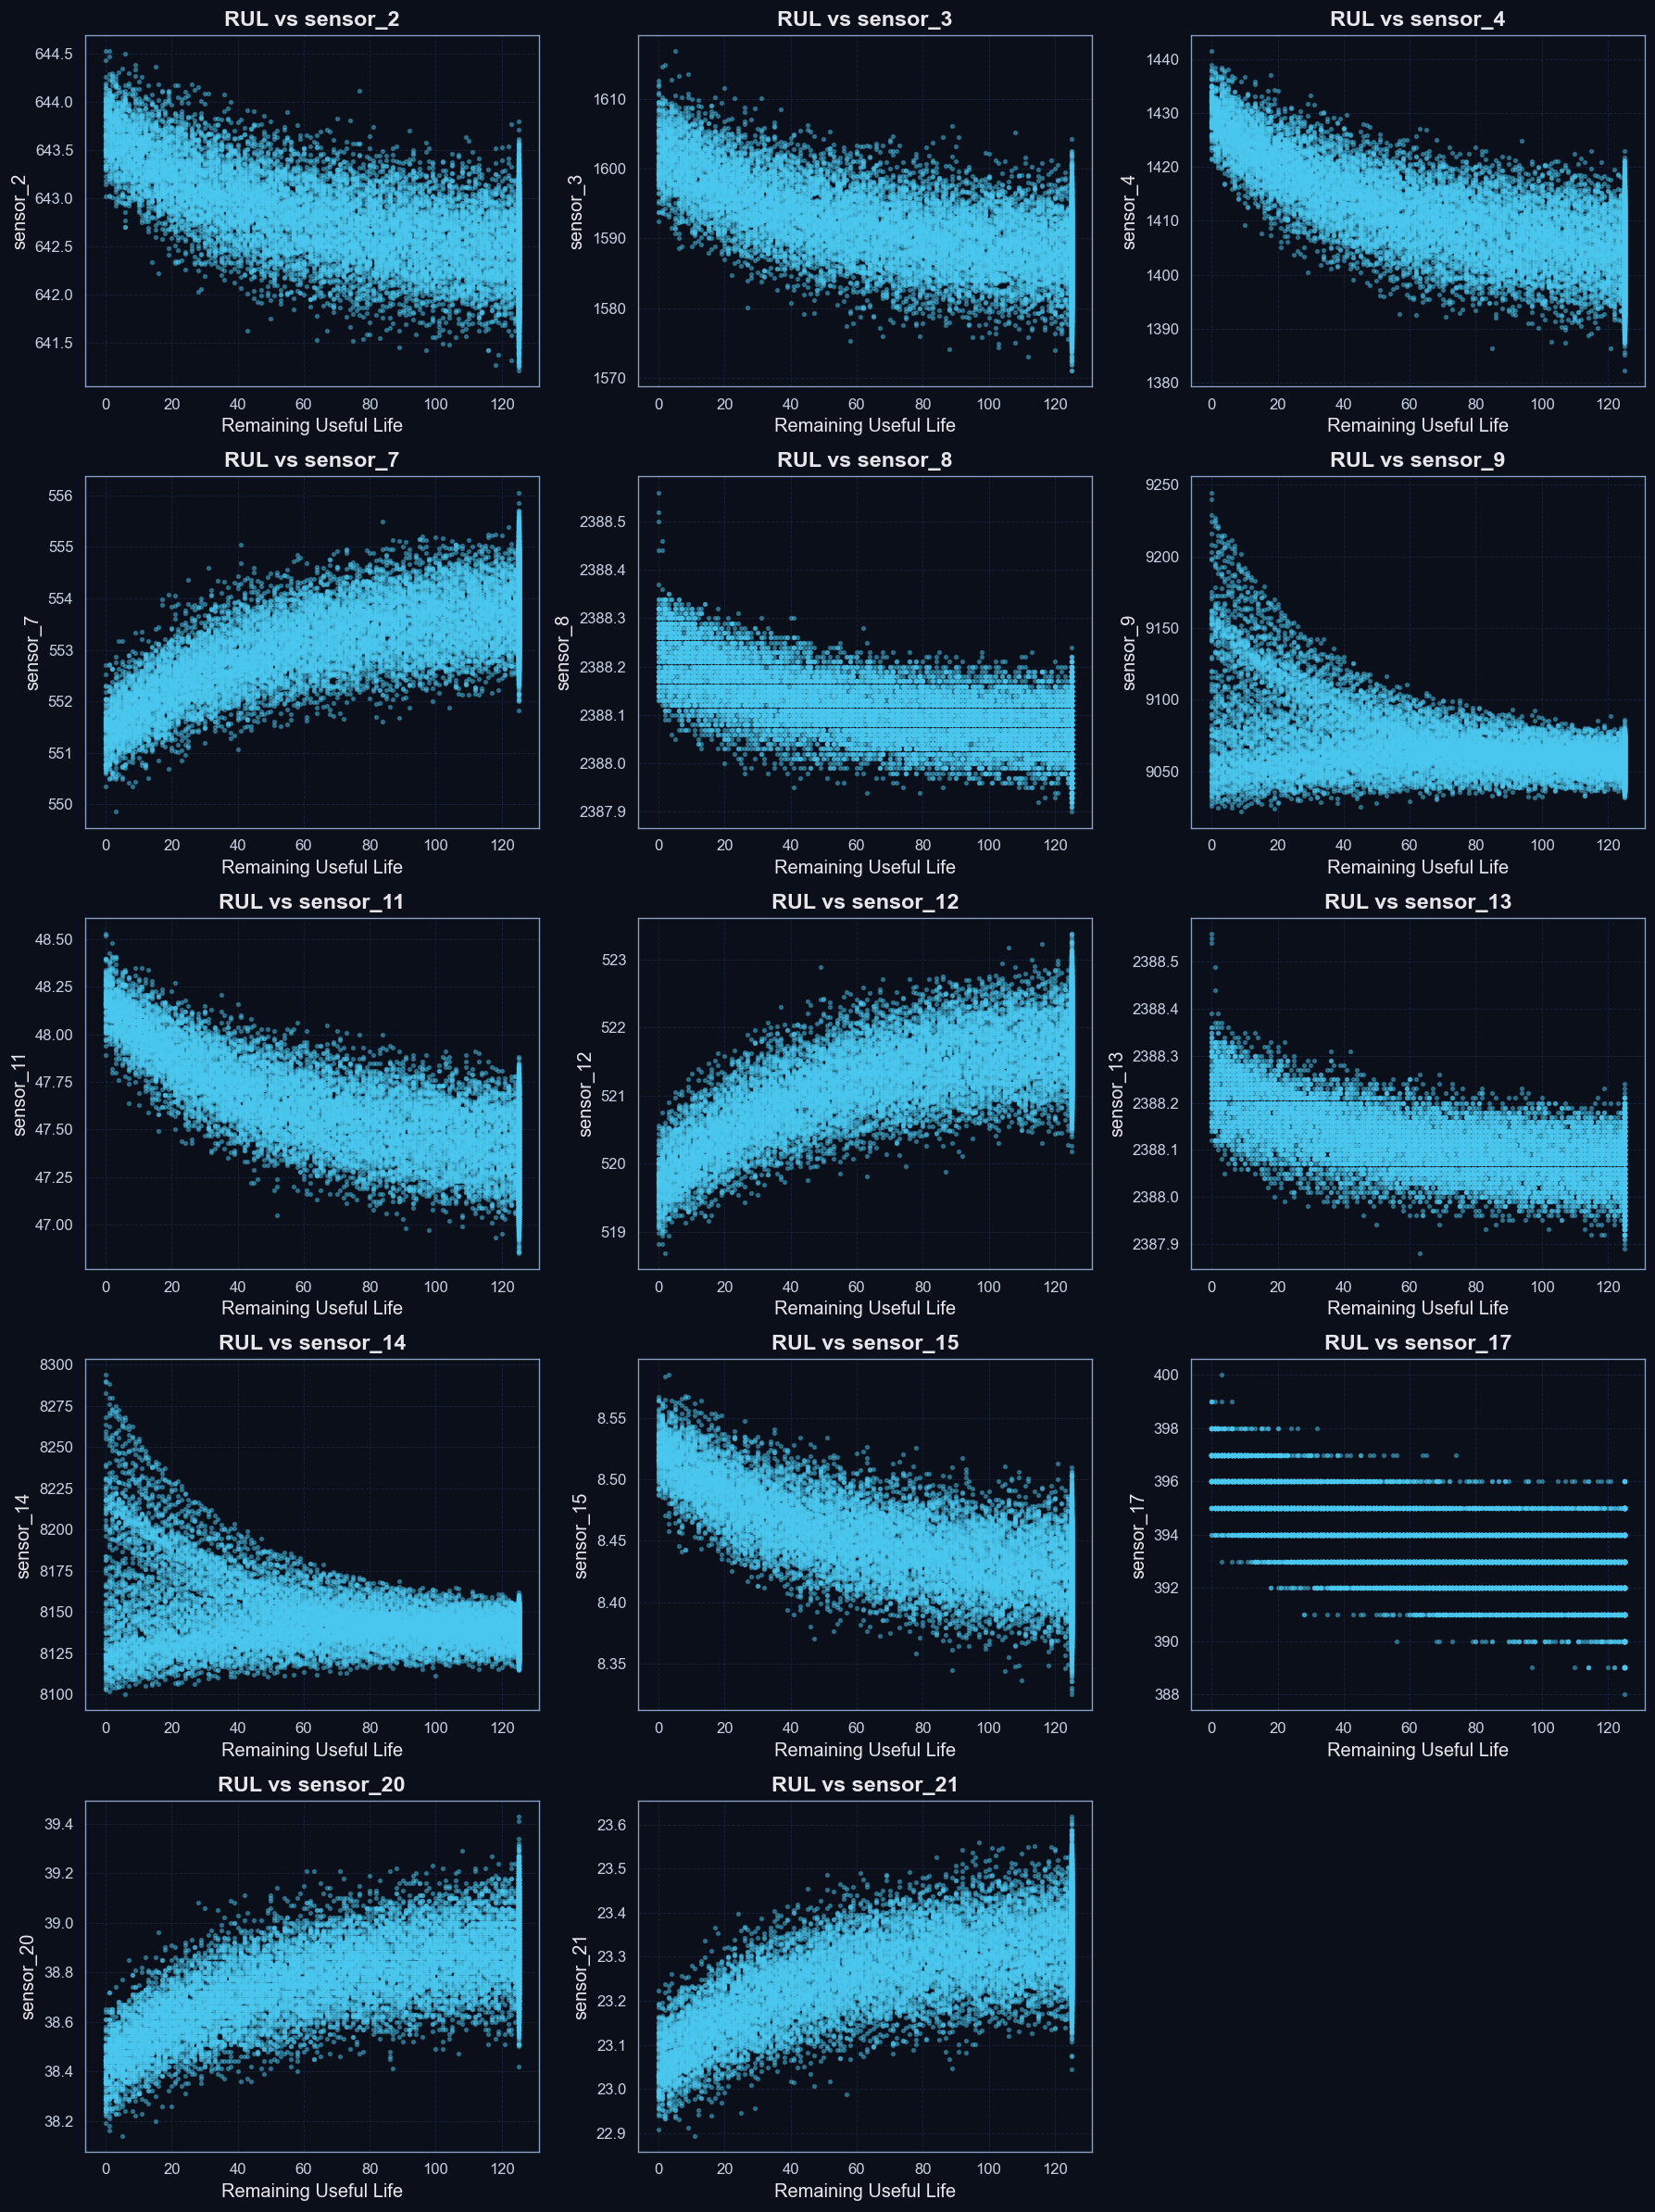

In [59]:
# Create subplots for RUL vs sensors to see which one give the best signal
n_sensors = len(sensor_col)
n_cols = 3
n_rows = math.ceil(n_sensors / n_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(5 * n_cols, 4 * n_rows)
)

axes = axes.flatten()

for i, s in enumerate(sensor_col):
    ax = axes[i]
    ax.scatter(df["RUL_capped"], df[s], s=5, alpha=0.4)
    ax.set_title(f"RUL vs {s}")
    ax.set_xlabel("Remaining Useful Life")
    ax.set_ylabel(s)

# Turn off unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
# plt.savefig('../plots/eda_q2_rul_vs_sensor_subplot.png', dpi=300, bbox_inches='tight')
plt.show()

In [60]:
strong_sensors = ['sensor_4', 'sensor_11', 'sensor_15']

## How do sensor signals evolve over an engine’s lifecycle, and what degradation trends appear as failure approaches?

By plotting sensor values over the fraction of engine life and overlaying a stratified sample of engines with short, medium, and long lifespans, we can see that the selected engines follow very similar trends, variance, and overall patterns across the three strong degradation sensors. While individual engines show some noise, the underlying signal behavior is consistent across units.

Across all sensors, the signal remains relatively flat early in the engine’s life, but the slope increases as the fraction of engine life grows, indicating non-linear behavior and increasingly strong trends. Overall, the degradation pattern appears monotonic and gradual rather than abrupt, with sensor values drifting and accelerating as the engine approaches failure.

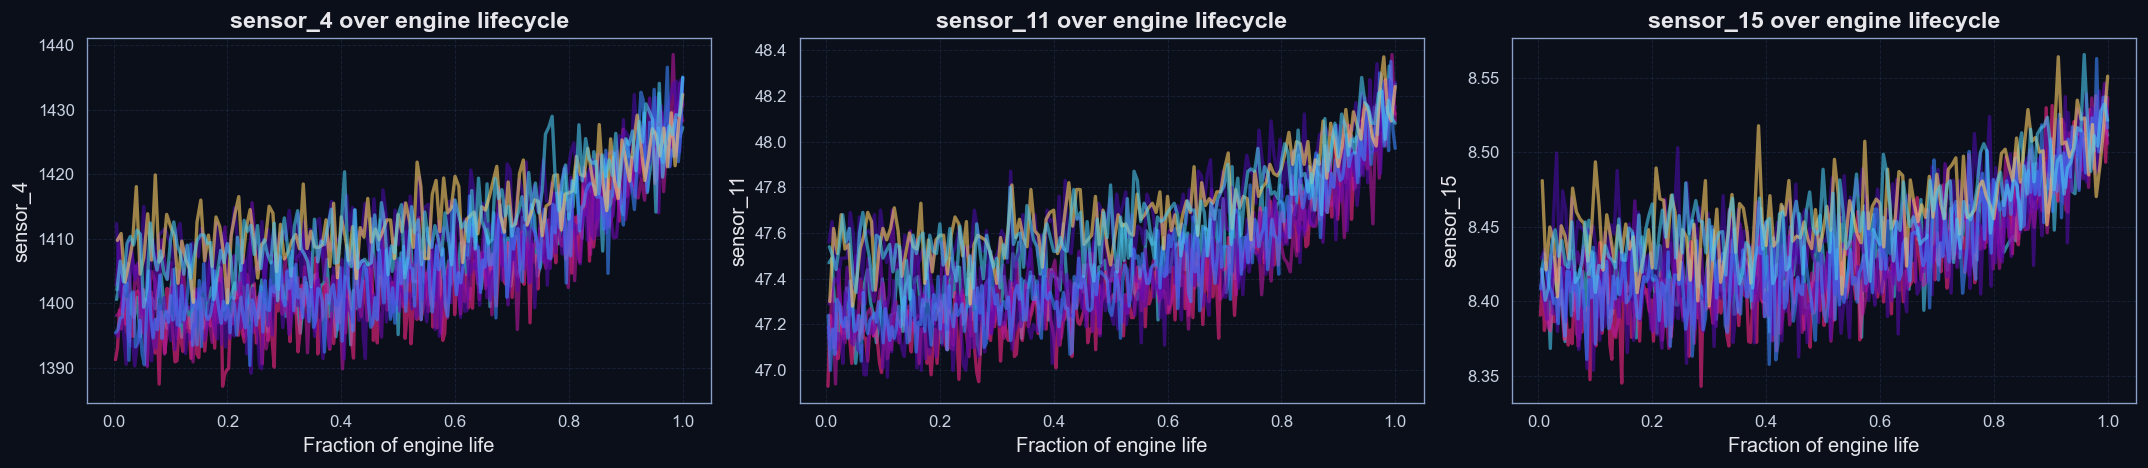

In [61]:
# Create subplots to show per engine degradation trends across different sensors
fig, axes = plt.subplots(
    1, len(strong_sensors),
    figsize=(6 * len(strong_sensors), 4)
)

if len(strong_sensors) == 1:
    axes = [axes]

for ax, s in zip(axes, strong_sensors):
    for u in selected_units:
        eng = df[df['unit_number'] == u].sort_values('life_fraction')
        ax.plot(
            eng['life_fraction'],
            eng[s],
            alpha=0.6
        )

    ax.set_title(f'{s} over engine lifecycle')
    ax.set_xlabel('Fraction of engine life')
    ax.set_ylabel(s)
    ax.grid(True)

plt.tight_layout()
# plt.savefig('../plots/eda_q1_sensors_over_engine_lives.png', dpi=300, bbox_inches='tight')
plt.show()

In [62]:
# Merge in life_group to dataframe using left join
df = df.merge(
    engine_life[['unit_number', 'life_group']],
    on='unit_number',
    how='left'
)

In [63]:
# Check that dataframes merged properly
df['life_group'].isna().sum()

0

In [64]:
df['life_group'].value_counts()

life_group
long      8291
medium    6993
short     5347
Name: count, dtype: int64

## Do degradation patterns differ across engines with different lifespan groups, or are sensor distributions consistent across those groups?

Across all sensors and life groups the median stays similar, same with the IQRs - this shows us that the sensors all show a similar degradation signal across all life groups for the given engines.

This suggests that degradation patterns captured by these sensors are not strongly dependent on an engine’s eventual lifespan. Instead, sensor behavior follows similar trends across engines, we may be able to use a global modeling approach rather than stratifying models by lifespan group.

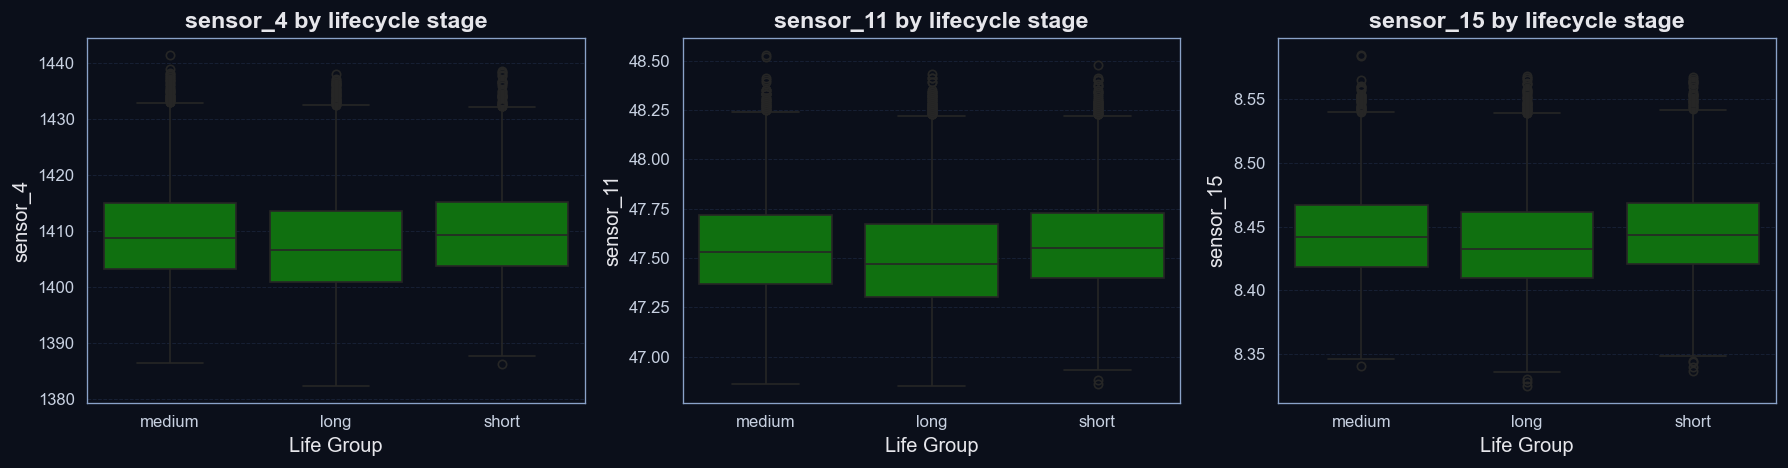

In [65]:
# Create subplot for plotting distribution
fig, axes = plt.subplots(
    1, len(strong_sensors),
    figsize=(5 * len(strong_sensors), 4),
    sharey=False
)

if len(strong_sensors) == 1:
    axes = [axes]

for ax, s in zip(axes, strong_sensors):
    sns.boxplot(data=df,
                x='life_group',
                y=s,
                ax=ax,
                color='green'
    )
    ax.set_title(f'{s} by lifecycle stage')
    ax.set_xlabel('Life Group')
    ax.set_ylabel(s)

plt.tight_layout()
# plt.savefig('../plots/eda_q3_sensor_distribution_by_life_group.png', dpi=300, bbox_inches='tight')
plt.show()